# A first pass at the two-site SFS in the Nelson *et al*. 2012 dataset

Daniel P. Rice

1 March 2018

# Introduction

While there are some concerns about the definitions of the target regions in the Nelson *et al.* data file S1, we would still like to be able to use the variants in file S2 to calculate the 1- and 2-site frequency spectra. In this document we'll take the coarsest possible approach: treating each target as a linked locus, ignoring missing data, and using all variant types (e.g. synonymous, nonsynonymous, intron) simultaneously. Later, we'll refine the analysis by stratifying by type, calculating statistics as a function of distance, and treating missing data more carefully.

## Importing the data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Import targets, renaming the start and stop bases of the whole target to the simpler "Start" and "Stop"

In [2]:
targets = pd.read_table('../data/NelsonEtal/S1_targets.txt')
targets = targets.rename(columns={'Exon.plus.50.bp.flanking.sequence.NCBI.36.Start': 'Start', 'Exon.plus.50.bp.flanking.sequence.NCBI.36.Stop': 'Stop'})
targets.head()

,Gene,Gene37,Chromosome,Exon.NCBI.36.Start,Exon.NCBI.36.Stop,Start,Stop,Entrez.Gene.ID,Transcript,Ensembl.Gene.ID,...,intron,upstream,downstream,code.cover,utr.cover,intron.cover,upstream.cover,downstream.cover,TargetLength,CoverLength
0,ABCB1,ABCB1,7,86970884,86971701,86970834,86971751,5243,NM_000927,ENSG00000085563,...,50,0,50,207,611,50,0,50,918,918
1,ABCB1,ABCB1,7,86973149,86973295,86973099,86973345,5243,NM_000927,ENSG00000085563,...,100,0,0,147,0,100,0,0,247,247
2,ABCB1,ABCB1,7,86976527,86976733,86976477,86976783,5243,NM_000927,ENSG00000085563,...,100,0,0,207,0,100,0,0,307,307
3,ABCB1,ABCB1,7,86982483,86982680,86982433,86982730,5243,NM_000927,ENSG00000085563,...,100,0,0,198,0,100,0,0,298,298
4,ABCB1,ABCB1,7,86983761,86983917,86983711,86983967,5243,NM_000927,ENSG00000085563,...,100,0,0,157,0,100,0,0,257,257


In [3]:
variants = pd.read_table('../data/NelsonEtal/S2_variants.txt')
variants.head()

/Users/dpr/miniconda3/envs/mmc_py35/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,local_identifier,NCBI_ss,VARIANT_ID,RSID,CHROMOSOME,POSITION,GENE,REF_ALLELE,REF_ALLELE_COUNT,VARIANT,...,African_American.NOBS,African_American.FREQ,UN_Southern_Asia.MA_COUNT,UN_Southern_Asia.NOBS,UN_Southern_Asia.FREQ,POLYPHEN_PREDICTION,PSIC,SIFT_PREDICTION,SIFT_SCORE,PHYLOP
0,chr1_17217782,491232555,chr1_17217782,NaN,1,17217782,SDHB,C,15563,T,...,848,0.001179,0,610,0.000000,NaN,NaN,NaN,NaN,-0.203
1,chr1_17217811,491232557,chr1_17217811,NaN,1,17217811,SDHB,T,18807,G,...,986,0.000000,0,748,0.000000,NaN,NaN,NaN,NaN,0.036
2,chr1_17217813,491232558,chr1_17217813,NaN,1,17217813,SDHB,T,19197,C,...,1002,0.000000,4,768,0.005208,NaN,NaN,NaN,NaN,-0.010
3,chr1_17217820,491232559,chr1_17217820,NaN,1,17217820,SDHB,A,20528,G,...,1052,0.000000,0,826,0.000000,NaN,NaN,NaN,NaN,1.030
4,chr1_17217853,491232560,chr1_17217853,NaN,1,17217853,SDHB,A,25125,G,...,1166,0.000000,0,1054,0.000000,NaN,NaN,NaN,NaN,-0.133


In the variant file, the chromosomes are coded as a mixture of strings and ints. Convert them all to strings and rename the column to match the chromosomes in the variant file.

In [4]:
variants = variants.rename(columns={'CHROMOSOME':'Chromosome'})
variants.Chromosome = variants.Chromosome.apply(str)
print(sorted(variants.Chromosome.unique(), key=lambda c: 23 if c=='X' else int(c)))

['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', 'X']


# Classifying variants by target

We're going to assign each variant to the sequencing target region where it is located, which we will treat as a "locus." First, we need to make sure that these targets are non-overlapping.

In [5]:
chroms = sorted(targets.Chromosome.unique(), key=lambda c: 23 if c=='X' else int(c))
print(chroms)

['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', 'X']


In [6]:
for c in chroms:
    targs = targets[targets.Chromosome == c].sort_values('Start')
    targs['NextStart'] = targs['Start'].shift(-1)
    targs['Diff'] = targs['NextStart'] - targs['Stop']
    print(c, targs.Diff.min())

1 6.0
2 3.0
3 4.0
4 11.0
5 6.0
6 73.0
7 17.0
8 4.0
9 7.0
10 61.0
11 11.0
12 2.0
13 35.0
14 134.0
15 15.0
16 279.0
17 4.0
18 195.0
19 10.0
20 14.0
21 626.0
22 90.0
X 3.0


All targets begin at least three basepairs after the previous target ends. That is, there is no overlap. So we can proceed to assign variants to targets.

In [7]:
varMAC = []
varNOBS = []
varFREQ = []
for row in targets[['Chromosome', 'Start', 'Stop']].itertuples():
    in_target = (variants.Chromosome==row.Chromosome) & (variants.POSITION >= row.Start) & (variants.POSITION <= row.Stop)
    # Only take mutations segregating in the european sample
    segregating = variants['Eur.MA_COUNT']>0
    target_vars = variants[in_target & segregating]
    varMAC.append(np.array(target_vars['Eur.MA_COUNT']))
    varNOBS.append(np.array(target_vars['Eur.NOBS']))
    varFREQ.append(np.array(target_vars['Eur.FREQ']))
targets['varMAC'] = varMAC
targets['varNOBS'] = varNOBS
targets['varFREQ'] = varFREQ

## Number of segregating sites per target

Having assigned variants to targets, let's look at some basic summaries of the number of segregating sites in each target.

In [8]:
targets['nseg'] = targets['varMAC'].apply(len)

In [9]:
targets.nseg.describe()

count    1989.000000
mean       19.374057
std        30.129363
min         0.000000
25%         7.000000
50%        11.000000
75%        18.000000
max       288.000000
Name: nseg, dtype: float64

The number of segregating variants in each target should be linear in the number of bases covered.

In [10]:
fseg_eur = targets.nseg.sum() / targets.CoverLength.sum()
print('Overall fraction of sites segregating in Europeans:', fseg_eur)

Overall fraction of sites segregating in Europeans: 0.0484330126251


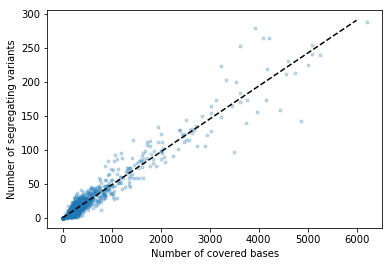

In [11]:
targets.plot(x='CoverLength', y='nseg', style='.', alpha=0.25, legend=False)
plt.plot(np.arange(6000), np.arange(6000)*fseg_eur, '--k')
plt.xlabel('Number of covered bases')
plt.ylabel('Number of segregating variants')

(0, 60)

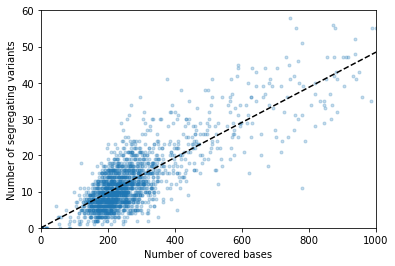

In [12]:
targets.plot(x='CoverLength', y='nseg', style='.', alpha=0.25, legend=False)
plt.plot(np.arange(6000), np.arange(6000)*fseg_eur, '--k')
plt.xlabel('Number of covered bases')
plt.ylabel('Number of segregating variants')
plt.xlim([0,1e3])
plt.ylim([0,60])

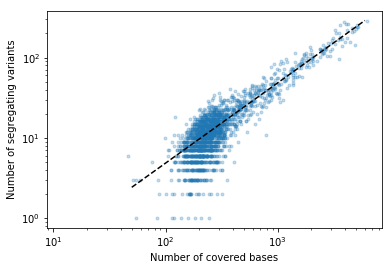

In [13]:
targets.plot(x='CoverLength', y='nseg', style='.', alpha=0.25, legend=False)
plt.plot(np.arange(50, 6000), np.arange(50, 6000)*fseg_eur, '--k')
plt.xlabel('Number of covered bases')
plt.ylabel('Number of segregating variants')
plt.xscale('log')
plt.yscale('log')

## Coverage in European samples.

Here, we'll look at the number of European samples observed for each variant. We know from the paper that 12,514 European diploid samples were sequenced.

In [14]:
n_eur = 12514 * 2
print(n_eur)

25028


In [15]:
variants['Eur.NOBS'].describe()

count    47675.000000
mean     24046.065653
std       1994.835280
min      11010.000000
25%      24230.000000
50%      24860.000000
75%      24990.000000
max      25030.000000
Name: Eur.NOBS, dtype: float64

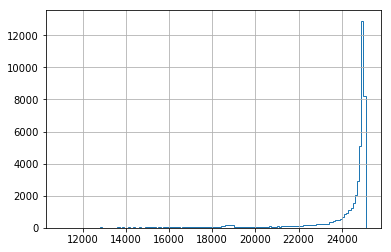

In [16]:
bins=np.arange(variants['Eur.NOBS'].min(), variants['Eur.NOBS'].max()+100, 100)
variants['Eur.NOBS'].hist(bins=bins, histtype='step', cumulative=False)
#plt.yscale('log')
#plt.xscale('log')

The number of European samples per variant is strongly clustered around n_eur. This suggests that we can largely treat the downsampling effects as minimal.

In [17]:
(variants['Eur.NOBS'] > n_eur).sum()

1627

It's curious that there are 1627 variants with n_obs in Europeans larger than the European sample size. I wonder what's going on here.

In [18]:
(variants['Eur.NOBS'].apply(int)%2 == 1).sum()

0

There are no odd numbers in Eur.NOBS, which implies that the individual genotypes are always called as diploids.

# The allele frequency spectrum

Before turning to the two-site frequency spectrum, we'll look at the one-site frequency spectrum to make sure that it looks roughly like the published results.

## Coarse summary

Table S5A gives the counts of mutations in various frequency bins. Let's try to verify these results. First, there should be 38535 variants in the European sample and 9140 that are present in the entire sample but missing from the European sequences.

In [19]:
n_noneur = np.sum(variants['Eur.FREQ'] == 0)
n_eur = len(variants) - n_noneur
print('Non-European:', n_noneur)
print('European:', n_eur)

Non-European: 9140
European: 38535


These numbers check out. Now we'll check singletons and doubletons, which should be 23,244 and 5,339 respectively.

In [20]:
n_sing = np.sum(variants['Eur.MA_COUNT'] == 1)
n_doub = np.sum(variants['Eur.MA_COUNT'] == 2)
print('Singleton:', n_sing)
print('Doubleton:', n_doub)

Singleton: 23244
Doubleton: 5339


These also check out. The rest of the table separates the variants by frequncy bins:

In [21]:
f_bins = np.array([0.0001, 0.001, 0.005, 0.02, 0.05, 0.50])
s5a_counts = np.array([6889, 1188, 557, 280, 1038])
counts = np.histogram(variants['Eur.FREQ'], bins=f_bins)[0]
print(np.vstack([s5a_counts, counts]))

[[6889 1188  557  280 1038]
 [7228 1189  557  280 1031]]


The two bins match, but the three do not. The numpy histogram function uses bins that are half-open to the right, while the SI uses bins that are half-open to the left. Also, the SI says that the lowest frequency bin excludes doubletons that happen to fall into this bin due to missing samples. We'll try to correct for this:

In [22]:
true_lowest_bin = (variants['Eur.FREQ'] > 0.0001) & (variants['Eur.FREQ'] <= 0.001) & (variants['Eur.MA_COUNT'] != 2)
true_second_bin = (variants['Eur.FREQ'] > 0.001) & (variants['Eur.FREQ'] <= 0.005)
print(true_lowest_bin.sum())
print(true_second_bin.sum())

6889
1188


That works and reproduces the correct values.

For the upper bin, we're missing seven mutations. The mismatch in the size of the European sample suggests that there may be variants with MAF larger than 0.5.

In [23]:
variants['Eur.FREQ'].describe()

count    47675.000000
mean         0.005088
std          0.036998
min          0.000000
25%          0.000040
50%          0.000040
75%          0.000081
max          0.524300
Name: Eur.FREQ, dtype: float64

In [24]:
true_highest_bin = variants['Eur.FREQ'] > 0.05
print(true_highest_bin.sum())

1038


There are in fact seven mutations with frequencies greater than 0.5. Including them, gives the correct count.

## Downsampled European SFS

To calculate allele frequency spectra, the authors downsample the European mutations to a sample size of 11,000, which they say leads to 84.6% of target sites being included (p. S14). They then use a hypergeometric model to calculate the expected downsampled sfs from the observed sfs.

In [25]:
n_ds = 11000*2
include = variants['Eur.NOBS'] >= n_ds
print(include.sum() / len(variants))

0.90045097011


Among variant sites, 90.0% meet the coverage criterion, compared with 84.6% of targeted sites. We can use the latter number to compute the total (monomorphic and polymorphic) sites to include:

In [28]:
fraction_target_included = 0.846
included_sites = np.ceil(targets.TargetLength.sum()*fraction_target_included)
print(included_sites)

722996.0


In [29]:
from scipy.stats import hypergeom

In [30]:
f = np.arange(1, n_ds//2)
SFS = np.zeros_like(f, dtype=float)

In [31]:
for row in variants[include][['Eur.NOBS', 'Eur.MA_COUNT']].itertuples():
    SFS += hypergeom(row[1], n_ds, row[2]).pmf(f)

Now, we can plot the downsampled site frequency spectrum. We'll chose the axis bounds, etc. to match Fig. 1A in the main text of the paper. They also plot the $1/f$ site frequency spectrum for two different estimates of $\theta$. We'll do the same.

In [32]:
sfs_neut = (1/f) + 1/(n_ds-f)

In [33]:
variable_fraction = np.sum(SFS) / included_sites
theta_w = variable_fraction / np.sum(1/np.arange(1,n_ds))

In [34]:
pi_weights = 2*f*(n_ds-f) / (n_ds*(n_ds-1))
theta_pi = np.dot(SFS, pi_weights) / included_sites

In [35]:
sfs_obs = SFS/included_sites

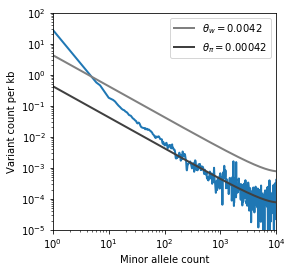

In [36]:
plt.figure(figsize=(4,4))
plt.loglog(f, sfs_obs*1e3, lw=2)
plt.loglog(f, sfs_neut*theta_w*1e3, color='0.5', lw=2, label='$\\theta_w = {0:.4f}$'.format(theta_w))
plt.loglog(f, sfs_neut*theta_pi*1e3, color='0.25', lw=2, label='$\\theta_{{\pi}} = {0:.5f}$'.format(theta_pi))

plt.legend()
plt.ylim([1e-5,1e2])
plt.xlim([1,1e4])
plt.xlabel('Minor allele count')
plt.ylabel('Variant count per kb')

The overall diversity is lower than in Fig. 1A, but this is probably because we're looking at the European subset and 1A plots the SFS for the whole data. Otherwise, there is qualitative agreement: $\theta_w \gg \theta_{\pi}$, and there is an excess of low-frequency mutations compared to the constant $N$ prediction. The other difference between this figure and 1A is that we're not breaking the mutations out by category, and we're including the (relatively few) upstream and downstream mutations.

The main text claims that the Europeans have 1 variant per 21 bp. We can calculate this two ways:
1. Total bases covered divided by total European variants
2. The inverse of our variable fraction estimate taking into account downsampling

In [37]:
print(targets.CoverLength.sum() / (variants['Eur.MA_COUNT']>0).sum())
print(1/variable_fraction)

20.6470740885
22.2906856823


The total bases/total variants ratio matches the claim of the paper. The other estimate gives slightly less diversity.

# Two-site frequency spectrum

Ideally, we would calculate the 2-site frequency spectrum as a function of distance for each of the feature categories. This would require more information than we currently have because we don't know the n_obs or features for monomorphic sites. We'll begin by treating all the sites equivalently and calculating the reduced SFS for each target.

In order to calculate the high/low-frequency counts, we need to chose a cutoff. To start with, we'll chose a minor allele count of 10. Then we'll classify each covered allele by it's European minor allele frequency: high, low, or zero.

In [38]:
cutoff = 10 / n_eur

In [39]:
targets['nMONO'] = targets['CoverLength'] - targets['nseg']

In [40]:
targets['nCOMPS'] = targets.CoverLength * (targets.CoverLength - 1)

In [42]:
cutoffs = np.arange(2,50,1) / n_eur
ratio = np.zeros_like(cutoffs)
for i, c in enumerate(cutoffs):
    lo = targets['varFREQ'].apply(lambda a: np.sum(a<=c))
    hi = targets['nseg'] - lo
    lohi = (lo*hi).sum() / targets['nCOMPS'].sum()
    ratio[i] = lohi / (lo.sum()*hi.sum() / targets['CoverLength'].sum()**2)    

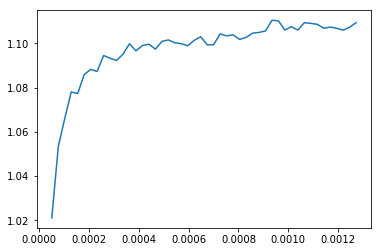

In [43]:
plt.plot(cutoffs, ratio)

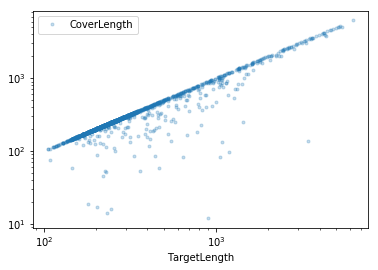

In [46]:
targets.plot(x='TargetLength', y='CoverLength', style='.', alpha=0.25)
plt.xscale('log')
plt.yscale('log')

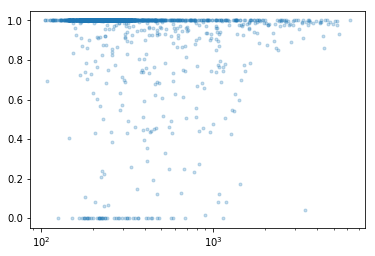

In [47]:
plt.plot(targets.TargetLength, targets.CoverLength/targets.TargetLength, '.', alpha=0.25)
plt.xscale('log')
#plt.yscale('log')

In [48]:
targets.TargetLength.describe()

count    1989.000000
mean      429.665661
std       612.814942
min       106.000000
25%       202.000000
50%       247.000000
75%       335.000000
max      6210.000000
Name: TargetLength, dtype: float64

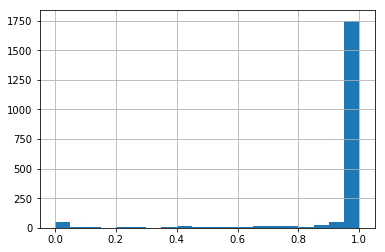

In [49]:
(targets.CoverLength/targets.TargetLength).hist(bins=np.arange(0,1.05,0.05))

436 1989
1279 1989
1477 1989
1545 1989
1636 1989
1749 1989


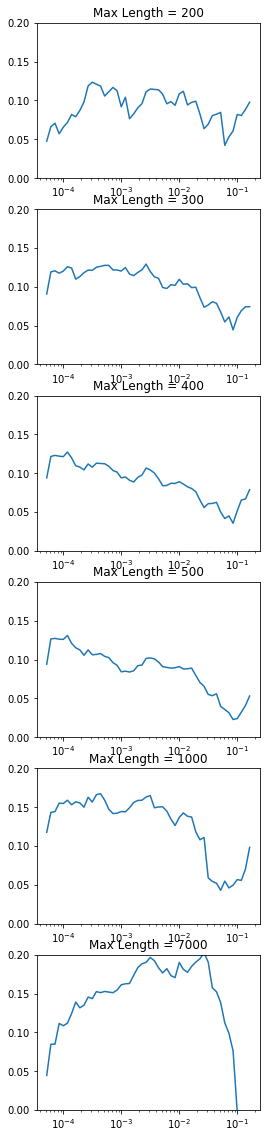

In [50]:
plt.figure(figsize=(4,20))
cutoffs = 2*np.logspace(0,3.5,50)/n_eur
cov_cutoff = 0.95
length_cutoffs = [200,300,400,500,1000,7000]
for i_l, lc in enumerate(length_cutoffs):
    t_subset = targets[(targets.TargetLength < lc) & (targets.CoverLength/targets.TargetLength > cov_cutoff)]
    print(len(t_subset), len(targets))
    ratio = np.zeros_like(cutoffs)
    for i, c in enumerate(cutoffs):
        lo = t_subset['varFREQ'].apply(lambda a: np.sum(a<=c))
        hi = t_subset['nseg'] - lo
        lohi = (lo*hi).sum() / t_subset['nCOMPS'].sum()
        ratio[i] = lohi / (lo.sum()*hi.sum() / t_subset['CoverLength'].sum()**2)
    plt.subplot(len(length_cutoffs), 1, i_l+1)
    plt.semilogx(cutoffs, np.log2(ratio))
    plt.title('Max Length = {}'.format(lc))
    plt.ylim([0.0,0.2])

In [58]:
def pi(mac, nobs):
    return 2*mac*(nobs-mac)/(nobs*(nobs-1))

In [74]:
#plt.figure(figsize=(4,20))
#cutoffs = 2*np.logspace(0,3.5,50)/n_eur
cov_cutoff = 0.95
t_cov = targets[targets.CoverLength/targets.TargetLength > cov_cutoff]
length_cutoffs = [100,175,200,225,250,300,500,1000,7000]

#for i_l, lc in enumerate(length_cutoffs):
for i in range(len(length_cutoffs) - 1):
    t_subset = t_cov[(targets.TargetLength >= length_cutoffs[i]) & (targets.TargetLength < length_cutoffs[i+1])]
    #print(len(t_subset), len(targets))
    ratio = np.zeros_like(cutoffs)
    mac = t_subset['varMAC']
    nobs = t_subset['varNOBS']
    pi_loc = pi(mac, nobs) #2*mac*(nobs-mac)/(nobs*(nobs-1))
    print('[{}, {}) {}'.format(length_cutoffs[i], length_cutoffs[i+1], len(t_subset)))
    print('{0:.5f}'.format(pi_loc.apply(np.sum).sum() / t_subset.CoverLength.sum()))
    #print(pi_loc.sum() / t_subset['CoverLength'].sum())
        #lo = (t_subset['varFREQ'].apply(lambda l: sum([x<=c for x in l])))
        #hi = t_subset['nseg'] - lo
        #lohi = (lo*hi).sum() / t_subset['nCOMPS'].sum()
        #ratio[i] = lohi / (lo.sum()*hi.sum() / t_subset['CoverLength'].sum()**2)
#    plt.subplot(len(length_cutoffs), 1, i_l+1)
#    plt.semilogx(cutoffs, np.log2(ratio))
#    plt.title('Max Length = {}'.format(lc))
#    plt.ylim([0.0,0.2])

[100, 175) 217
0.00060
[175, 200) 219
0.00051
[200, 225) 282
0.00036
[225, 250) 236
0.00043
[250, 300) 325
0.00046
[300, 500) 266
0.00043
[500, 1000) 91
0.00042
[1000, 7000) 113
0.00043


/Users/dpr/miniconda3/envs/mmc_py35/lib/python3.5/site-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


In [57]:
(2*targets.varMAC*(targets.varNOBS-targets.varMAC) / (targets.varNOBS*(targets.varNOBS-1))).apply(np.sum).sum() / targets.CoverLength.sum()

0.0004426256884254701

# Misc.

In [40]:
sum([True, False, True])

2

# Conclusions

I've identified 4 types of inconsistencies in supplimentary data file S1:
1. There are fewer total bases in targets and fewer coding bases per gene than reported in the SI.
2. The right flanking region of some targets extends more than 50bp beyond the exon stop position.
3. For some targets, the number of coding and UTR bases excedes the exon length and even the target length.
4. For some targets, the number of intron bases is negative.

The first inconsistency could be due to file S1 excluding some targets that were used to calculate the numbers reported in the SI. The second could be due to either an error in identifying exons, or the fact that some targets truly extend beyond 50bp past the exon for an unknown reason.

The third and fourth inconsistencies are potentially more problematic. I believe that either: (1) coding and UTR bases are not mutually exclusive, (2) these bases were misidentified/misreported, or (3) the target regions were misreported. In any case, the negative values for intron bases are an error. A further complication is that the total number of coding and UTR bases match the numbers reported in the main text.

The next step will be to compare the exon start positions with an Ensembl BioMart query to check consistency with that database.